In [18]:
import os
import fsspec
import xarray as xr
import vcm

import pandas as pd

import intake

import numpy as np

In [17]:
url = os.environ['PROG_RUN_LOCATION']
grid_c384 = vcm.open_tiles('gs://vcm-ml-data/2020-01-06-C384-grid-spec-with-area-dx-dy/grid_spec')

In [9]:
catalog = intake.open_catalog("../../catalog.yml")

In [3]:
ds = vcm.open_tiles(url +"/atmos_dt_atmos").load()
# ds.to_zarr("local.zarr")
#ds = xr.open_zarr("local.zarr/")

(<Figure size 432x288 with 2 Axes>,
 array(<cartopy.mpl.geoaxes.GeoAxesSubplot object at 0x7f95d3b58850>,
       dtype=object),
 <matplotlib.colorbar.Colorbar at 0x7f95d399d850>)

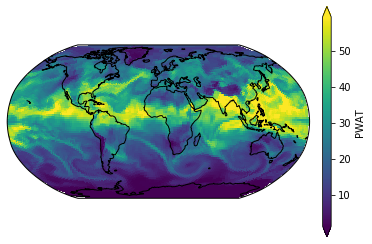

In [4]:
vcm.plot_cube(vcm.mappable_var(ds.isel(time=0), 'PWAT'))

(<Figure size 432x288 with 2 Axes>,
 array(<cartopy.mpl.geoaxes.GeoAxesSubplot object at 0x7f95d3d5b2d0>,
       dtype=object),
 <matplotlib.colorbar.Colorbar at 0x7f95d39b3290>)

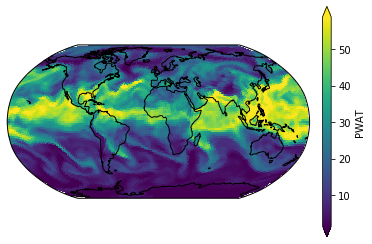

In [5]:
vcm.plot_cube(vcm.mappable_var(ds.isel(time=-1), 'PWAT'))

# RMS Diagnostics

In [6]:
resampled = ds.resample(time='3H', label='right').mean()

/home/noahb/miniconda3/envs/fv3net/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [10]:
verification = catalog['40day_c384_atmos_8xdaily'].to_dask()

# open grid spec
verification = verification.merge(grid_c384)

# block average data
verification_c48 = vcm.cubedsphere.weighted_block_average(verification, verification.area, 8, x_dim="grid_xt", y_dim="grid_yt")

# subselect
verification_c48 = verification_c48.sel(time=resampled.time[:-1]) # don't use last time point. there is some trouble

In [11]:
def rms(x, y, w, dims):
    return np.sqrt(((x-y)**2 * w).sum(dims) / w.sum(dims))

In [12]:
rms_pwat = rms(resampled, verification_c48, resampled.area, dims=['grid_xt', 'grid_yt', 'tile'])

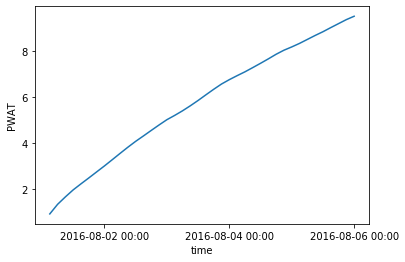

In [13]:
rms_pwat.PWAT.plot()

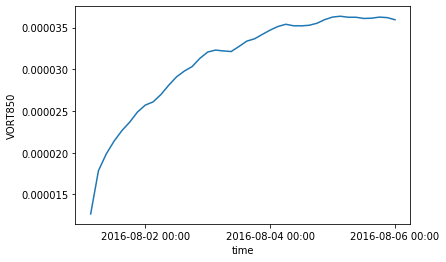

In [14]:
rms_pwat.VORT850.plot()

# Comparison maps of PWAT

In [15]:
common_vars = list(set(resampled) & set(verification_c48))

merged = xr.concat([resampled[common_vars], verification_c48[common_vars]], dim=pd.Index(['progrun', 'truth'], name='run'))
merged = merged.merge(resampled[vcm.cubedsphere.constants.GRID_VARS], compat='override')

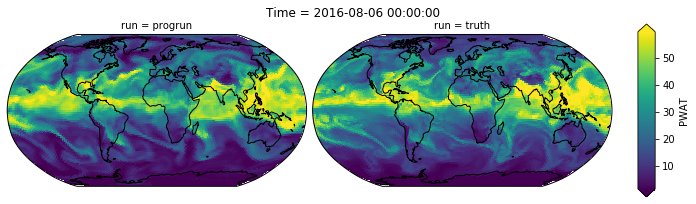

In [16]:
fig = vcm.plot_cube(vcm.mappable_var(merged.isel(time=-2), 'PWAT'), col='run')[0]
fig.suptitle(f"Time = {merged.time[-2].item()}")
fig.set_figwidth(12)